In [1]:
from tensorflow.keras.models import load_model
import numpy as np
import pandas as pd
import sys
import os
import glob
import shutil
import logging
import time
import subprocess
import copy

2023-04-10 12:19:18.931008: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-10 12:19:19.005110: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-10 12:19:25.189498: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
X_train=np.load('X_train.npy')
y_train=np.load('y_train.npy')
X_val=np.load('X_val.npy')
y_val=np.load('y_val.npy')

In [3]:
from tensorflow import keras
import tensorflow as tf
keras.backend.clear_session()

In [36]:
from tensorflow.keras import layers

model=tf.keras.Sequential([
    layers.Conv2D(filters=32, kernel_size=7, strides=(1, 1), input_shape=(1000,21,1), activation='relu'),
    #layers.BatchNormalization(),

    layers.Conv2D(filters=64, kernel_size=7, strides=(1, 1), input_shape=(1000,21,1), activation='relu'),
    #layers.BatchNormalization(),
    
    layers.Conv2D(filters=128, kernel_size=7, strides=(1, 1), input_shape=(1000,21,1), activation='relu'),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),
    layers.Flatten(),

    layers.Dense(64),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.2),

    layers.Dense(128),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.2),

    layers.Dense(256),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.2),

    layers.Dense(2, activation='sigmoid'),

])

In [4]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Activation, Concatenate, Dropout
from tensorflow.keras.models import Model

input_layer = Input(shape=(1000, 21, 1))

conv1 = Conv2D(filters=128, kernel_size=(4, 21), strides=(1, 1), padding='valid', activation='relu')(input_layer)
conv2 = Conv2D(filters=128, kernel_size=(8, 21), strides=(1, 1), padding='valid', activation='relu')(input_layer)
conv3 = Conv2D(filters=128, kernel_size=(16, 21), strides=(1, 1), padding='valid', activation='relu')(input_layer)
#conv4 = Conv2D(filters=128, kernel_size=(32, 21), strides=(1, 1), padding='valid', activation='relu')(input_layer)

pool1 = MaxPooling2D(pool_size=(997, 1))(conv1)
pool2 = MaxPooling2D(pool_size=(993, 1))(conv2)
pool3 = MaxPooling2D(pool_size=(985, 1))(conv3)
#pool4 = MaxPooling2D(pool_size=(969, 1))(conv4)

flatten1 = Flatten()(pool1)
flatten2 = Flatten()(pool2)
flatten3 = Flatten()(pool3)
#flatten4 = Flatten()(pool4)

bn1 = BatchNormalization()(flatten1)
bn2 = BatchNormalization()(flatten2)
bn3 = BatchNormalization()(flatten3)
#bn4 = BatchNormalization()(flatten4)

concat = Concatenate()([bn1, bn2, bn3])

dense1 = Dense(256)(concat)
bn4 = BatchNormalization()(dense1)
act1 = Activation('relu')(bn4)
dropout1= Dropout(0.3)(act1)

dense2 = Dense(256)(dropout1)
bn5 = BatchNormalization()(dense2)
act2 = Activation('relu')(bn5)
dropout2=Dropout(0.3)(act2)

dense3 = Dense(256)(dropout2)
bn6 = BatchNormalization()(dense3)
act3 = Activation('relu')(bn6)
dropout3=Dropout(0.3)(act3)

output_layer = Dense(2, activation='sigmoid')(dropout3)

model = Model(inputs=input_layer, outputs=output_layer)


In [5]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1000, 21, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 997, 1, 128)  10880       ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 993, 1, 128)  21632       ['input_1[0][0]']                
                                                                                                  
 conv2d_2 (Conv2D)              (None, 985, 1, 128)  43136       ['input_1[0][0]']            

In [6]:
#with batch size mentioned
#with early stopping

from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=10, # how many epochs to wait before stopping
    restore_best_weights=True,
)

model.compile(
    optimizer=tf.keras.optimizers.SGD(lr=0.1),
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val,y_val),
    batch_size=128,
    callbacks=[early_stopping],
    epochs=40)

2023-04-10 12:22:42.160590: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 5453196000 exceeds 10% of free system memory.


Epoch 1/40
507/508 [============================>.] - ETA: 0s - loss: 0.6083 - binary_accuracy: 0.6714

2023-04-10 12:24:22.817023: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1363320000 exceeds 10% of free system memory.


508/508 [==============================] - 102s 193ms/step - loss: 0.6083 - binary_accuracy: 0.6714 - val_loss: 0.5884 - val_binary_accuracy: 0.7035
Epoch 2/40
508/508 [==============================] - 90s 177ms/step - loss: 0.5340 - binary_accuracy: 0.7315 - val_loss: 0.5078 - val_binary_accuracy: 0.7485
Epoch 3/40
508/508 [==============================] - 89s 175ms/step - loss: 0.4955 - binary_accuracy: 0.7609 - val_loss: 0.5044 - val_binary_accuracy: 0.7518
Epoch 4/40
508/508 [==============================] - 89s 175ms/step - loss: 0.4622 - binary_accuracy: 0.7838 - val_loss: 0.4881 - val_binary_accuracy: 0.7681
Epoch 5/40
508/508 [==============================] - 89s 176ms/step - loss: 0.4343 - binary_accuracy: 0.7999 - val_loss: 0.4918 - val_binary_accuracy: 0.7707
Epoch 6/40
508/508 [==============================] - 91s 179ms/step - loss: 0.4071 - binary_accuracy: 0.8150 - val_loss: 0.5098 - val_binary_accuracy: 0.7614
Epoch 7/40
508/508 [==============================] - 92

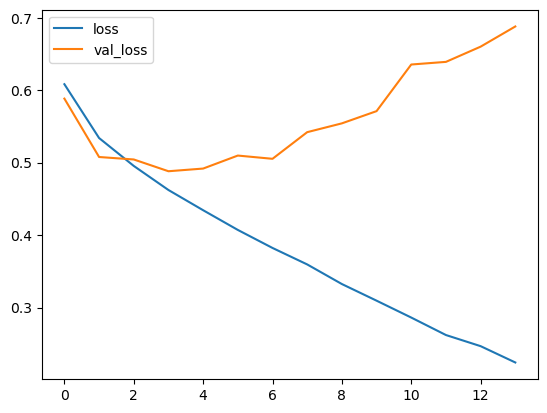

In [7]:
# Show the learning curves
import matplotlib
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();

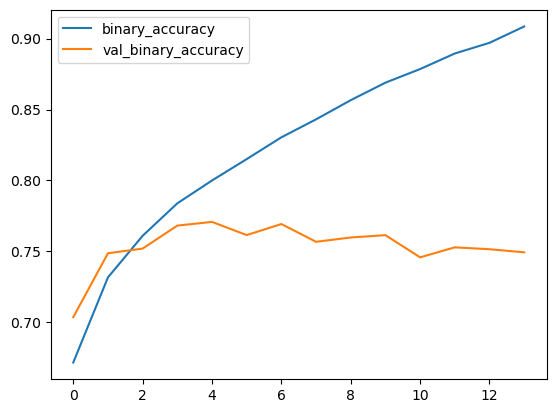

In [8]:
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

In [10]:
os.mkdir('model_01_40')

In [11]:
#saving history
history_df.to_csv('model_01_40/model_01_40.csv')

In [12]:
from keras.models import model_from_json

# Replace 'model' with the name of your trained model
model_name = 'model_01_40/model_01_40'

# Save the model architecture as a JSON file
model_json = model.to_json()
with open(model_name + '.json', 'w') as json_file:
    json_file.write(model_json)

# Save the model weights as an H5 file
model.save_weights(model_name + '_weights.h5')

#saving complete model
model.save(model_name + '.h5')

In [10]:
keras.backend.clear_session()

In [11]:
#model 4
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Activation, Concatenate, Dropout
from tensorflow.keras.models import Model

input_layer = Input(shape=(1000, 21, 1))

conv1 = Conv2D(filters=128, kernel_size=(4, 21), strides=(1, 1), padding='valid', activation='relu')(input_layer)
conv2 = Conv2D(filters=128, kernel_size=(8, 21), strides=(1, 1), padding='valid', activation='relu')(input_layer)
conv3 = Conv2D(filters=128, kernel_size=(16, 21), strides=(1, 1), padding='valid', activation='relu')(input_layer)
conv4 = Conv2D(filters=128, kernel_size=(32, 21), strides=(1, 1), padding='valid', activation='relu')(input_layer)

pool1 = MaxPooling2D(pool_size=(997, 1))(conv1)
pool2 = MaxPooling2D(pool_size=(993, 1))(conv2)
pool3 = MaxPooling2D(pool_size=(985, 1))(conv3)
pool4 = MaxPooling2D(pool_size=(969, 1))(conv4)

flatten1 = Flatten()(pool1)
flatten2 = Flatten()(pool2)
flatten3 = Flatten()(pool3)
flatten4 = Flatten()(pool4)

bn1 = BatchNormalization()(flatten1)
bn2 = BatchNormalization()(flatten2)
bn3 = BatchNormalization()(flatten3)
bn4 = BatchNormalization()(flatten4)

concat = Concatenate()([bn1, bn2, bn3, bn4])

dense1 = Dense(128)(concat)
bn4 = BatchNormalization()(dense1)
act1 = Activation('relu')(bn4)
dropout1= Dropout(0.3)(act1)

dense2 = Dense(256)(dropout1)
bn5 = BatchNormalization()(dense2)
act2 = Activation('relu')(bn5)
dropout2=Dropout(0.3)(act2)

dense3 = Dense(512)(dropout2)
bn6 = BatchNormalization()(dense3)
act3 = Activation('relu')(bn6)
dropout3=Dropout(0.3)(act3)

output_layer = Dense(2, activation='sigmoid')(dropout3)

model = Model(inputs=input_layer, outputs=output_layer)


In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1000, 21, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 997, 1, 128)  10880       ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 993, 1, 128)  21632       ['input_1[0][0]']                
                                                                                                  
 conv2d_2 (Conv2D)              (None, 985, 1, 128)  43136       ['input_1[0][0]']            

In [13]:
#with batch size mentioned
#with early stopping

from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=10, # how many epochs to wait before stopping
    restore_best_weights=True,
)

model.compile(
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val,y_val),
    batch_size=128,
    callbacks=[early_stopping],
    epochs=40)

Epoch 1/40


2023-04-06 00:06:00.464894: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 5453196000 exceeds 10% of free system memory.


508/508 [==============================] - 214s 418ms/step - loss: 0.5963 - binary_accuracy: 0.6851 - val_loss: 0.6147 - val_binary_accuracy: 0.6544
Epoch 2/40
508/508 [==============================] - 214s 422ms/step - loss: 0.5143 - binary_accuracy: 0.7465 - val_loss: 0.5024 - val_binary_accuracy: 0.7551
Epoch 3/40
508/508 [==============================] - 216s 424ms/step - loss: 0.4644 - binary_accuracy: 0.7806 - val_loss: 0.4958 - val_binary_accuracy: 0.7630
Epoch 4/40
508/508 [==============================] - 216s 425ms/step - loss: 0.4150 - binary_accuracy: 0.8110 - val_loss: 0.5188 - val_binary_accuracy: 0.7535
Epoch 5/40
508/508 [==============================] - 216s 425ms/step - loss: 0.3674 - binary_accuracy: 0.8380 - val_loss: 0.5335 - val_binary_accuracy: 0.7587
Epoch 6/40
508/508 [==============================] - 216s 426ms/step - loss: 0.3250 - binary_accuracy: 0.8589 - val_loss: 0.5662 - val_binary_accuracy: 0.7523
Epoch 7/40
508/508 [==============================]

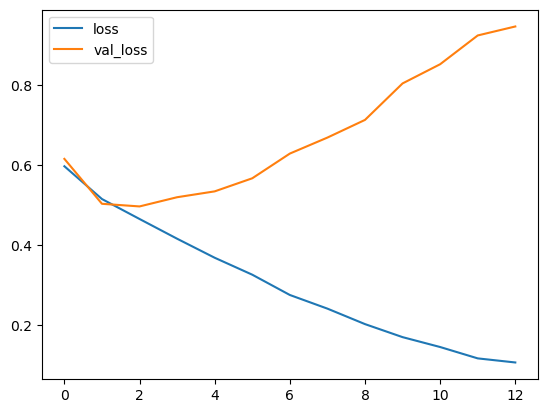

In [14]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();

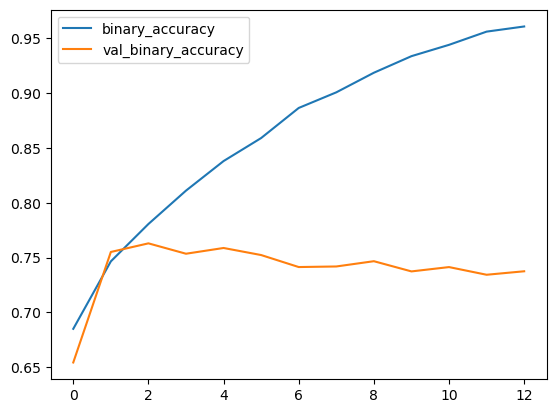

In [15]:
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

In [16]:
keras.backend.clear_session()

In [17]:
#model 5
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Activation, Concatenate, Dropout
from tensorflow.keras.models import Model

input_layer = Input(shape=(1000, 21, 1))

conv1 = Conv2D(filters=128, kernel_size=(4, 21), strides=(1, 1), padding='valid', activation='relu')(input_layer)
conv2 = Conv2D(filters=128, kernel_size=(8, 21), strides=(1, 1), padding='valid', activation='relu')(input_layer)
conv3 = Conv2D(filters=128, kernel_size=(16, 21), strides=(1, 1), padding='valid', activation='relu')(input_layer)
conv4 = Conv2D(filters=128, kernel_size=(32, 21), strides=(1, 1), padding='valid', activation='relu')(input_layer)

pool1 = MaxPooling2D(pool_size=(997, 1))(conv1)
pool2 = MaxPooling2D(pool_size=(993, 1))(conv2)
pool3 = MaxPooling2D(pool_size=(985, 1))(conv3)
pool4 = MaxPooling2D(pool_size=(969, 1))(conv4)

flatten1 = Flatten()(pool1)
flatten2 = Flatten()(pool2)
flatten3 = Flatten()(pool3)
flatten4 = Flatten()(pool4)

bn1 = BatchNormalization()(flatten1)
bn2 = BatchNormalization()(flatten2)
bn3 = BatchNormalization()(flatten3)
bn4 = BatchNormalization()(flatten4)

concat = Concatenate()([bn1, bn2, bn3, bn4])

dense1 = Dense(128)(concat)
bn4 = BatchNormalization()(dense1)
act1 = Activation('relu')(bn4)
dropout1= Dropout(0.3)(act1)

dense2 = Dense(256)(dropout1)
bn5 = BatchNormalization()(dense2)
act2 = Activation('relu')(bn5)
dropout2=Dropout(0.3)(act2)

dense3 = Dense(512)(dropout2)
bn6 = BatchNormalization()(dense3)
act3 = Activation('relu')(bn6)
dropout3=Dropout(0.3)(act3)

output_layer = Dense(2, activation='sigmoid')(dropout3)

model = Model(inputs=input_layer, outputs=output_layer)


In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1000, 21, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 997, 1, 128)  10880       ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 993, 1, 128)  21632       ['input_1[0][0]']                
                                                                                                  
 conv2d_2 (Conv2D)              (None, 985, 1, 128)  43136       ['input_1[0][0]']            

In [19]:
#with batch size mentioned
#with early stopping

from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=10, # how many epochs to wait before stopping
    restore_best_weights=True,
)

model.compile(
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val,y_val),
    batch_size=64,
    callbacks=[early_stopping],
    epochs=40)

Epoch 1/40


2023-04-06 00:52:41.856657: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 5453196000 exceeds 10% of free system memory.


1015/1015 [==============================] - 215s 209ms/step - loss: 0.5821 - binary_accuracy: 0.6933 - val_loss: 0.5243 - val_binary_accuracy: 0.7283
Epoch 2/40
1015/1015 [==============================] - 213s 210ms/step - loss: 0.4988 - binary_accuracy: 0.7594 - val_loss: 0.5054 - val_binary_accuracy: 0.7485
Epoch 3/40
1015/1015 [==============================] - 213s 210ms/step - loss: 0.4449 - binary_accuracy: 0.7951 - val_loss: 0.4948 - val_binary_accuracy: 0.7583
Epoch 4/40
1015/1015 [==============================] - 214s 211ms/step - loss: 0.3929 - binary_accuracy: 0.8255 - val_loss: 0.5199 - val_binary_accuracy: 0.7529
Epoch 5/40
1015/1015 [==============================] - 215s 212ms/step - loss: 0.3447 - binary_accuracy: 0.8520 - val_loss: 0.5541 - val_binary_accuracy: 0.7452
Epoch 6/40
1015/1015 [==============================] - 216s 213ms/step - loss: 0.2955 - binary_accuracy: 0.8755 - val_loss: 0.5763 - val_binary_accuracy: 0.7499
Epoch 7/40
1015/1015 [=================

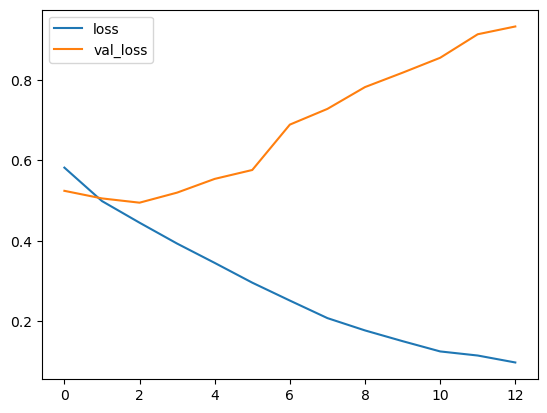

In [20]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();

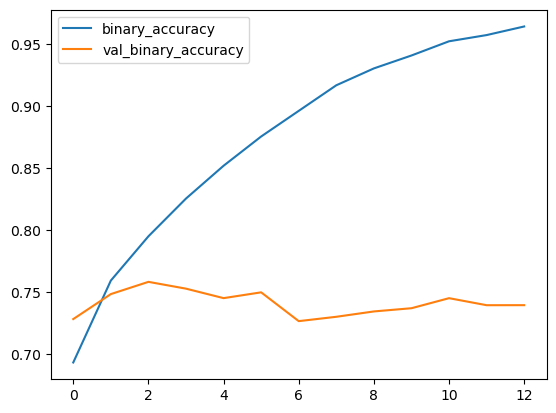

In [21]:
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

In [22]:
keras.backend.clear_session()

In [23]:
#model 6
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Activation, Concatenate, Dropout
from tensorflow.keras.models import Model

input_layer = Input(shape=(1000, 21, 1))

conv1 = Conv2D(filters=128, kernel_size=(4, 21), strides=(1, 1), padding='valid', activation='relu')(input_layer)
conv2 = Conv2D(filters=128, kernel_size=(8, 21), strides=(1, 1), padding='valid', activation='relu')(input_layer)
conv3 = Conv2D(filters=128, kernel_size=(16, 21), strides=(1, 1), padding='valid', activation='relu')(input_layer)
conv4 = Conv2D(filters=128, kernel_size=(32, 21), strides=(1, 1), padding='valid', activation='relu')(input_layer)

pool1 = MaxPooling2D(pool_size=(997, 1))(conv1)
pool2 = MaxPooling2D(pool_size=(993, 1))(conv2)
pool3 = MaxPooling2D(pool_size=(985, 1))(conv3)
pool4 = MaxPooling2D(pool_size=(969, 1))(conv4)

flatten1 = Flatten()(pool1)
flatten2 = Flatten()(pool2)
flatten3 = Flatten()(pool3)
flatten4 = Flatten()(pool4)

bn1 = BatchNormalization()(flatten1)
bn2 = BatchNormalization()(flatten2)
bn3 = BatchNormalization()(flatten3)
bn4 = BatchNormalization()(flatten4)

concat = Concatenate()([bn1, bn2, bn3, bn4])

dense1 = Dense(128)(concat)
bn4 = BatchNormalization()(dense1)
act1 = Activation('relu')(bn4)
dropout1= Dropout(0.3)(act1)

dense2 = Dense(256)(dropout1)
bn5 = BatchNormalization()(dense2)
act2 = Activation('relu')(bn5)
dropout2=Dropout(0.3)(act2)

dense3 = Dense(512)(dropout2)
bn6 = BatchNormalization()(dense3)
act3 = Activation('relu')(bn6)
dropout3=Dropout(0.3)(act3)

output_layer = Dense(2, activation='sigmoid')(dropout3)

model = Model(inputs=input_layer, outputs=output_layer)


In [24]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1000, 21, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 997, 1, 128)  10880       ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 993, 1, 128)  21632       ['input_1[0][0]']                
                                                                                                  
 conv2d_2 (Conv2D)              (None, 985, 1, 128)  43136       ['input_1[0][0]']            

In [25]:
#with batch size mentioned
#with early stopping

from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=10, # how many epochs to wait before stopping
    restore_best_weights=True,
)

model.compile(
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val,y_val),
    batch_size=254,
    callbacks=[early_stopping],
    epochs=40)

Epoch 1/40


2023-04-06 01:39:31.805292: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 5453196000 exceeds 10% of free system memory.


256/256 [==============================] - 211s 817ms/step - loss: 0.6226 - binary_accuracy: 0.6554 - val_loss: 0.7509 - val_binary_accuracy: 0.3905
Epoch 2/40
256/256 [==============================] - 209s 818ms/step - loss: 0.5391 - binary_accuracy: 0.7243 - val_loss: 0.6854 - val_binary_accuracy: 0.5585
Epoch 3/40
256/256 [==============================] - 211s 824ms/step - loss: 0.4945 - binary_accuracy: 0.7587 - val_loss: 0.5440 - val_binary_accuracy: 0.7175
Epoch 4/40
256/256 [==============================] - 210s 821ms/step - loss: 0.4541 - binary_accuracy: 0.7864 - val_loss: 0.5172 - val_binary_accuracy: 0.7437
Epoch 5/40
256/256 [==============================] - 210s 822ms/step - loss: 0.4146 - binary_accuracy: 0.8100 - val_loss: 0.5337 - val_binary_accuracy: 0.7426
Epoch 6/40
256/256 [==============================] - 211s 824ms/step - loss: 0.3740 - binary_accuracy: 0.8338 - val_loss: 0.5438 - val_binary_accuracy: 0.7436
Epoch 7/40
256/256 [==============================]

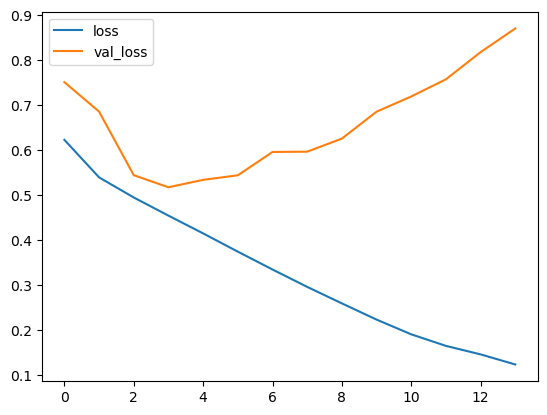

In [26]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();

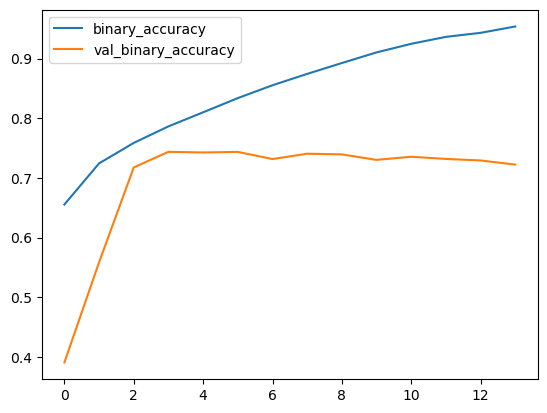

In [27]:
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

In [28]:
keras.backend.clear_session()

In [29]:
#model 7
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Activation, Concatenate, Dropout
from tensorflow.keras.models import Model

input_layer = Input(shape=(1000, 21, 1))

conv1 = Conv2D(filters=128, kernel_size=(4, 21), strides=(1, 1), padding='valid', activation='relu')(input_layer)
conv2 = Conv2D(filters=128, kernel_size=(8, 21), strides=(1, 1), padding='valid', activation='relu')(input_layer)
conv3 = Conv2D(filters=128, kernel_size=(16, 21), strides=(1, 1), padding='valid', activation='relu')(input_layer)
conv4 = Conv2D(filters=128, kernel_size=(32, 21), strides=(1, 1), padding='valid', activation='relu')(input_layer)

pool1 = MaxPooling2D(pool_size=(997, 1))(conv1)
pool2 = MaxPooling2D(pool_size=(993, 1))(conv2)
pool3 = MaxPooling2D(pool_size=(985, 1))(conv3)
pool4 = MaxPooling2D(pool_size=(969, 1))(conv4)

flatten1 = Flatten()(pool1)
flatten2 = Flatten()(pool2)
flatten3 = Flatten()(pool3)
flatten4 = Flatten()(pool4)

bn1 = BatchNormalization()(flatten1)
bn2 = BatchNormalization()(flatten2)
bn3 = BatchNormalization()(flatten3)
bn4 = BatchNormalization()(flatten4)

concat = Concatenate()([bn1, bn2, bn3, bn4])

dense1 = Dense(128)(concat)
bn4 = BatchNormalization()(dense1)
act1 = Activation('relu')(bn4)
dropout1= Dropout(0.3)(act1)

dense2 = Dense(256)(dropout1)
bn5 = BatchNormalization()(dense2)
act2 = Activation('relu')(bn5)
dropout2=Dropout(0.3)(act2)

dense3 = Dense(512)(dropout2)
bn6 = BatchNormalization()(dense3)
act3 = Activation('relu')(bn6)
dropout3=Dropout(0.3)(act3)

output_layer = Dense(2, activation='sigmoid')(dropout3)

model = Model(inputs=input_layer, outputs=output_layer)


In [30]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1000, 21, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 997, 1, 128)  10880       ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 993, 1, 128)  21632       ['input_1[0][0]']                
                                                                                                  
 conv2d_2 (Conv2D)              (None, 985, 1, 128)  43136       ['input_1[0][0]']            

In [31]:
#with batch size mentioned
#with early stopping

from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=10, # how many epochs to wait before stopping
    restore_best_weights=True,
)

model.compile(
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val,y_val),
    batch_size=32,
    callbacks=[early_stopping],
    epochs=40)

2023-04-06 02:28:55.350747: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 5453196000 exceeds 10% of free system memory.


Epoch 1/40
2029/2029 [==============================] - 226s 110ms/step - loss: 0.5667 - binary_accuracy: 0.7069 - val_loss: 0.5143 - val_binary_accuracy: 0.7419
Epoch 2/40
2029/2029 [==============================] - 224s 111ms/step - loss: 0.4864 - binary_accuracy: 0.7662 - val_loss: 0.4816 - val_binary_accuracy: 0.7696
Epoch 3/40
2029/2029 [==============================] - 225s 111ms/step - loss: 0.4326 - binary_accuracy: 0.8023 - val_loss: 0.4998 - val_binary_accuracy: 0.7637
Epoch 4/40
2029/2029 [==============================] - 225s 111ms/step - loss: 0.3824 - binary_accuracy: 0.8326 - val_loss: 0.5038 - val_binary_accuracy: 0.7648
Epoch 5/40
2029/2029 [==============================] - 225s 111ms/step - loss: 0.3306 - binary_accuracy: 0.8594 - val_loss: 0.5375 - val_binary_accuracy: 0.7558
Epoch 6/40
2029/2029 [==============================] - 225s 111ms/step - loss: 0.2815 - binary_accuracy: 0.8826 - val_loss: 0.5805 - val_binary_accuracy: 0.7535
Epoch 7/40
2029/2029 [======

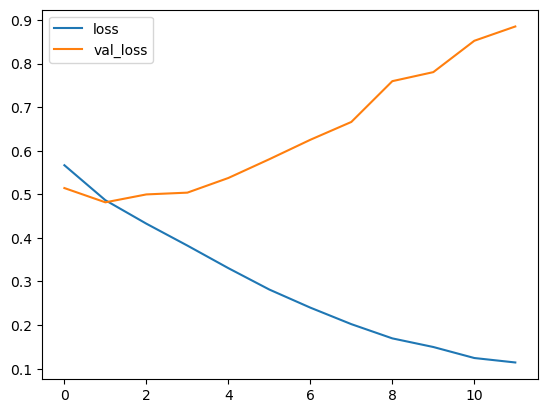

In [32]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();

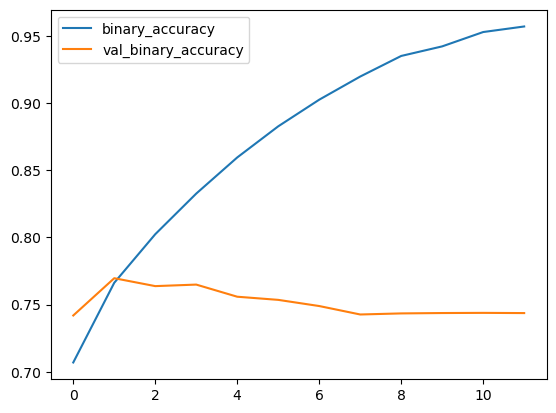

In [33]:
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

In [34]:
#using class weights to counter imbalance in data

In [60]:
from sklearn.utils import class_weight
class_weights=class_weight.compute_class_weight(class_weight='balanced', classes= [0,1] ,y= df[1].to_list())

In [61]:
df=pd.DataFrame(y_train)
df[0].to_list()

[0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0

In [62]:
class_weights=dict(zip([0,1],class_weights))
class_weights

{0: 0.8124624549459352, 1: 1.3000961268874915}

In [63]:
from tensorflow import keras
import tensorflow as tf
keras.backend.clear_session()

In [64]:
#model 8
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Activation, Concatenate, Dropout
from tensorflow.keras.models import Model

input_layer = Input(shape=(1000, 21, 1))

conv1 = Conv2D(filters=128, kernel_size=(4, 21), strides=(1, 1), padding='valid', activation='relu')(input_layer)
conv2 = Conv2D(filters=128, kernel_size=(8, 21), strides=(1, 1), padding='valid', activation='relu')(input_layer)
conv3 = Conv2D(filters=128, kernel_size=(16, 21), strides=(1, 1), padding='valid', activation='relu')(input_layer)
conv4 = Conv2D(filters=128, kernel_size=(32, 21), strides=(1, 1), padding='valid', activation='relu')(input_layer)

pool1 = MaxPooling2D(pool_size=(997, 1))(conv1)
pool2 = MaxPooling2D(pool_size=(993, 1))(conv2)
pool3 = MaxPooling2D(pool_size=(985, 1))(conv3)
pool4 = MaxPooling2D(pool_size=(969, 1))(conv4)

flatten1 = Flatten()(pool1)
flatten2 = Flatten()(pool2)
flatten3 = Flatten()(pool3)
flatten4 = Flatten()(pool4)

bn1 = BatchNormalization()(flatten1)
bn2 = BatchNormalization()(flatten2)
bn3 = BatchNormalization()(flatten3)
bn4 = BatchNormalization()(flatten4)

concat = Concatenate()([bn1, bn2, bn3, bn4])

dense1 = Dense(256)(concat)
bn4 = BatchNormalization()(dense1)
act1 = Activation('relu')(bn4)
dropout1= Dropout(0.3)(act1)

dense2 = Dense(256)(dropout1)
bn5 = BatchNormalization()(dense2)
act2 = Activation('relu')(bn5)
dropout2=Dropout(0.3)(act2)

dense3 = Dense(256)(dropout2)
bn6 = BatchNormalization()(dense3)
act3 = Activation('relu')(bn6)
dropout3=Dropout(0.3)(act3)

output_layer = Dense(2, activation='sigmoid')(dropout3)

model = Model(inputs=input_layer, outputs=output_layer)


In [65]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1000, 21, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 997, 1, 128)  10880       ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 993, 1, 128)  21632       ['input_1[0][0]']                
                                                                                                  
 conv2d_2 (Conv2D)              (None, 985, 1, 128)  43136       ['input_1[0][0]']            

In [66]:
#with batch size mentioned
#with early stopping

from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=10, # how many epochs to wait before stopping
    restore_best_weights=True,
)

model.compile(
    optimizer=tf.keras.optimizers.SGD(lr=0.1),
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val,y_val),
    batch_size=128,
    callbacks=[early_stopping],
    class_weight=class_weights,
    epochs=40)

Epoch 1/40
508/508 [==============================] - 187s 362ms/step - loss: 0.6232 - binary_accuracy: 0.6616 - val_loss: 0.7075 - val_binary_accuracy: 0.5421
Epoch 2/40
508/508 [==============================] - 193s 380ms/step - loss: 0.5410 - binary_accuracy: 0.7264 - val_loss: 0.5431 - val_binary_accuracy: 0.7209
Epoch 3/40
508/508 [==============================] - 210s 413ms/step - loss: 0.4905 - binary_accuracy: 0.7590 - val_loss: 0.5418 - val_binary_accuracy: 0.7281
Epoch 4/40
508/508 [==============================] - 217s 427ms/step - loss: 0.4468 - binary_accuracy: 0.7883 - val_loss: 0.5573 - val_binary_accuracy: 0.7301
Epoch 5/40
508/508 [==============================] - 221s 435ms/step - loss: 0.4006 - binary_accuracy: 0.8177 - val_loss: 0.5664 - val_binary_accuracy: 0.7344
Epoch 6/40
508/508 [==============================] - 222s 438ms/step - loss: 0.3495 - binary_accuracy: 0.8453 - val_loss: 0.5750 - val_binary_accuracy: 0.7429
Epoch 7/40
508/508 [====================

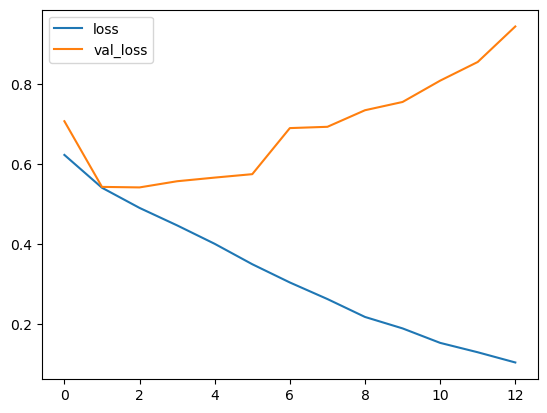

In [68]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();

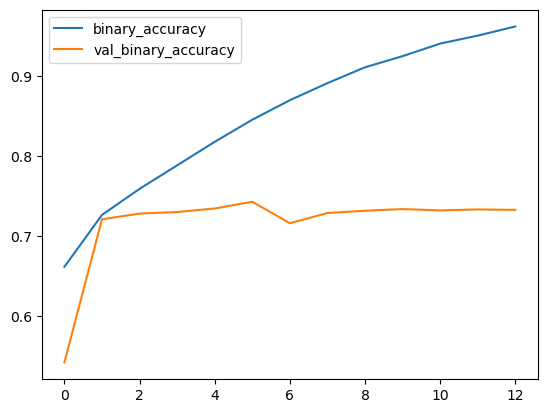

In [69]:
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

In [70]:
keras.backend.clear_session()

In [71]:
from tensorflow.keras import layers

model=tf.keras.Sequential([
    layers.Conv2D(filters=32, kernel_size=7, strides=(1, 1), input_shape=(1000,21,1), activation='relu'),
    #layers.BatchNormalization(),

    layers.Conv2D(filters=64, kernel_size=7, strides=(1, 1), input_shape=(1000,21,1), activation='relu'),
    #layers.BatchNormalization(),
    
    layers.Conv2D(filters=128, kernel_size=7, strides=(1, 1), input_shape=(1000,21,1), activation='relu'),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),
    layers.Flatten(),

    layers.Dense(64),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.2),

    layers.Dense(128),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.2),

    layers.Dense(256),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.2),

    layers.Dense(2, activation='sigmoid'),

])

In [72]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 994, 15, 32)       1600      
                                                                 
 conv2d_1 (Conv2D)           (None, 988, 9, 64)        100416    
                                                                 
 conv2d_2 (Conv2D)           (None, 982, 3, 128)       401536    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 491, 1, 128)      0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 491, 1, 128)      512       
 ormalization)                                                   
                                                                 
 flatten (Flatten)           (None, 62848)             0

In [73]:
#with batch size mentioned
#with early stopping

from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=10, # how many epochs to wait before stopping
    restore_best_weights=True,
)

model.compile(
    optimizer=tf.keras.optimizers.SGD(lr=0.1),
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val,y_val),
    batch_size=128,
    callbacks=[early_stopping],
    #class_weight=class_weights,
    epochs=40)

Epoch 1/40
346/508 [===================>..........] - ETA: 19:31 - loss: 0.6321 - binary_accuracy: 0.6531

KeyboardInterrupt: 

In [67]:
X_train.shape

(64919, 1000, 21, 1)

In [59]:
np.unique(y_val[:,1], return_counts=True)

(array([0., 1.]), array([9989, 6241]))